## Dev Fast Binary GLM-HMM Functions

Writing some quick functions to fit GLM-HMM with variable states to binary data for meeting visuals this week. Eventually, this code will be cleaned up into it's own experiment and visualization class.

Next steps!!!

- save out- does it work? can you clear the plot
- set up notebooks for 1, 2, and 3 states and run for each animal to get a general idea of what is happening
- grab some of lencas old figures

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import ssm
from multiglm.data.dataset_loader import *
from multiglm.features.design_matrix_generator import *
from multiglm.features.design_matrix_generator_PWM import *
from multiglm.visualizations.ssm_visualizer import *
from multiglm.experiments.experiment_binary_glmhmm import *

%load_ext autoreload
%autoreload 2

sns.set_context('talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Run Binary GLMHMM

This is a quick object I wrote under experiments to easily run all animals through a binary glmhmm with the same set of parameters and save a summary figure. 

It does not do: train/test splitting, hyperparameter optimization, or cross-validation. Or, save any of the data. It's really just for quick run with visualizations and will likely be modified to have more depth.

In [6]:
dmg_config = {
    "s_a": lambda df: (standardize(df.s_a)),
    "s_b": lambda df: (standardize(df.s_b)),
    "bias": lambda df: (add_bias_column(df)),
    "session": lambda df: (copy(df.session)),
    "labels": binary_choice_labels(),
}

model_config = {
    "n_states": 2,
    "n_features": 3,  # will need to infer from DMG at some point
    "n_categories": 2,
    "transitions": "standard",
}

params = {
    "animal_ids": ["W075"],
    "seed": 0,
    "dmg_config": dmg_config,
    "model_config": model_config,
    "save_path": "/Users/jessbreda/Desktop/github/animal-learning/figures/glmhmm/initial_fits",
}
test = RunBinaryGLMHMM(params)
test.run()

Loading data for animal ids:  ['W075']
Running GLM-HMM for animal W075
DMG: Creating data matrix with columns: dict_keys(['s_a', 's_b', 'bias', 'session'])
DMG: Creating labels with column: choice.
DMG: Dropping 39771 nan rows from data and labels.
DMG: Binary encoding labels.
SSM Preprocessing: 552 sessions found.


Converged to LP: -59205.1:  26%|██▋       | 53/200 [00:23<01:05,  2.23it/s]
/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


## Code used to Test RunBinaryGLMHMM

In [29]:
animal_id = ["W075"]

## LOAD (typically for all, then iterate over animal_id)
df = DatasetLoader(
    animal_ids=animal_id, data_type="new_trained", relative_data_path="../data/"
).load_data()

dmg_config = {
    "s_a": lambda df: (standardize(df.s_a)),
    "s_b": lambda df: (standardize(df.s_b)),
    "bias": lambda df: (add_bias_column(df)),
    "session": lambda df: (copy(df.session)),
    "labels": binary_choice_labels(),
}

dmg = DesignMatrixGeneratorPWM(df.reset_index(), dmg_config, verbose=True)
X, y = dmg.create()
Xs, ys = prepare_data_for_ssm(X, y)

# Model

# Initialize
glm_hmm = ssm.HMM(
    K=2,
    D=1,
    M=3,
    observations="input_driven_obs",
    observation_kwargs=dict(C=2, prior_sigma=1),
    transitions="standard",
    transition_kwargs=None,
)

N_iters = 200  # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = glm_hmm.fit(
    ys,  # ys
    inputs=Xs,
    method="em",
    num_iters=N_iters,
    tolerance=10**-4,
)

Loading data for animal ids:  ['W075']
DMG: Creating data matrix with columns: dict_keys(['bias', 's_a', 's_b', 'session'])
DMG: Creating labels with column: choice.
DMG: Dropping 39771 nan rows from data and labels.
DMG: Binary encoding labels.
SSM Preprocessing: 552 sessions found.


Converged to LP: -59179.1:  28%|██▊       | 57/200 [00:26<01:06,  2.15it/s]


In [21]:
glm_hmm.log_probability(ys, inputs=Xs), glm_hmm.log_likelihood(ys, inputs=Xs)

(-38851.2727818764, -38804.31255817605)

In [24]:
def plot_bernoulli_glmhmm_summary(fit_ll, fit_HMM_object, animal_id, Xs, ys, seed=0):
    layout = """
        ABBB
        CDDD
        EFFF
    """

    fig = plt.figure(constrained_layout=True, figsize=(23, 13))
    ax_dict = fig.subplot_mosaic(layout)  # ax to plot to
    plt.suptitle(f"{animal_id} GLM-HMM Summary Plot", fontweight="semibold")

    plot_transition_matrix(fit_HMM_object.transitions.params, ax=ax_dict["A"])
    weights = fit_HMM_object.observations.params
    plot_bernoulli_weights_by_state(
        weights, ax=ax_dict["C"], feature_names=["bias", "s_a", "s_b"]
    )
    plot_log_probs_over_iters(fit_ll, ax=ax_dict["E"], color="black")

    posterior_state_probs = get_posterior_state_probs(fit_HMM_object, ys, inputs=Xs)

    # get 3 random sessions given between 0 and len(ys)
    np.random.seed(seed)
    random_sessions = np.random.choice(range(len(ys)), 3)
    plots = ["B", "D", "F"]
    for session, plot in zip(random_sessions, plots):
        plot_state_posterior(
            posterior_state_probs[session],
            ax=ax_dict[plot],
            title=f"Session {session}",
        )

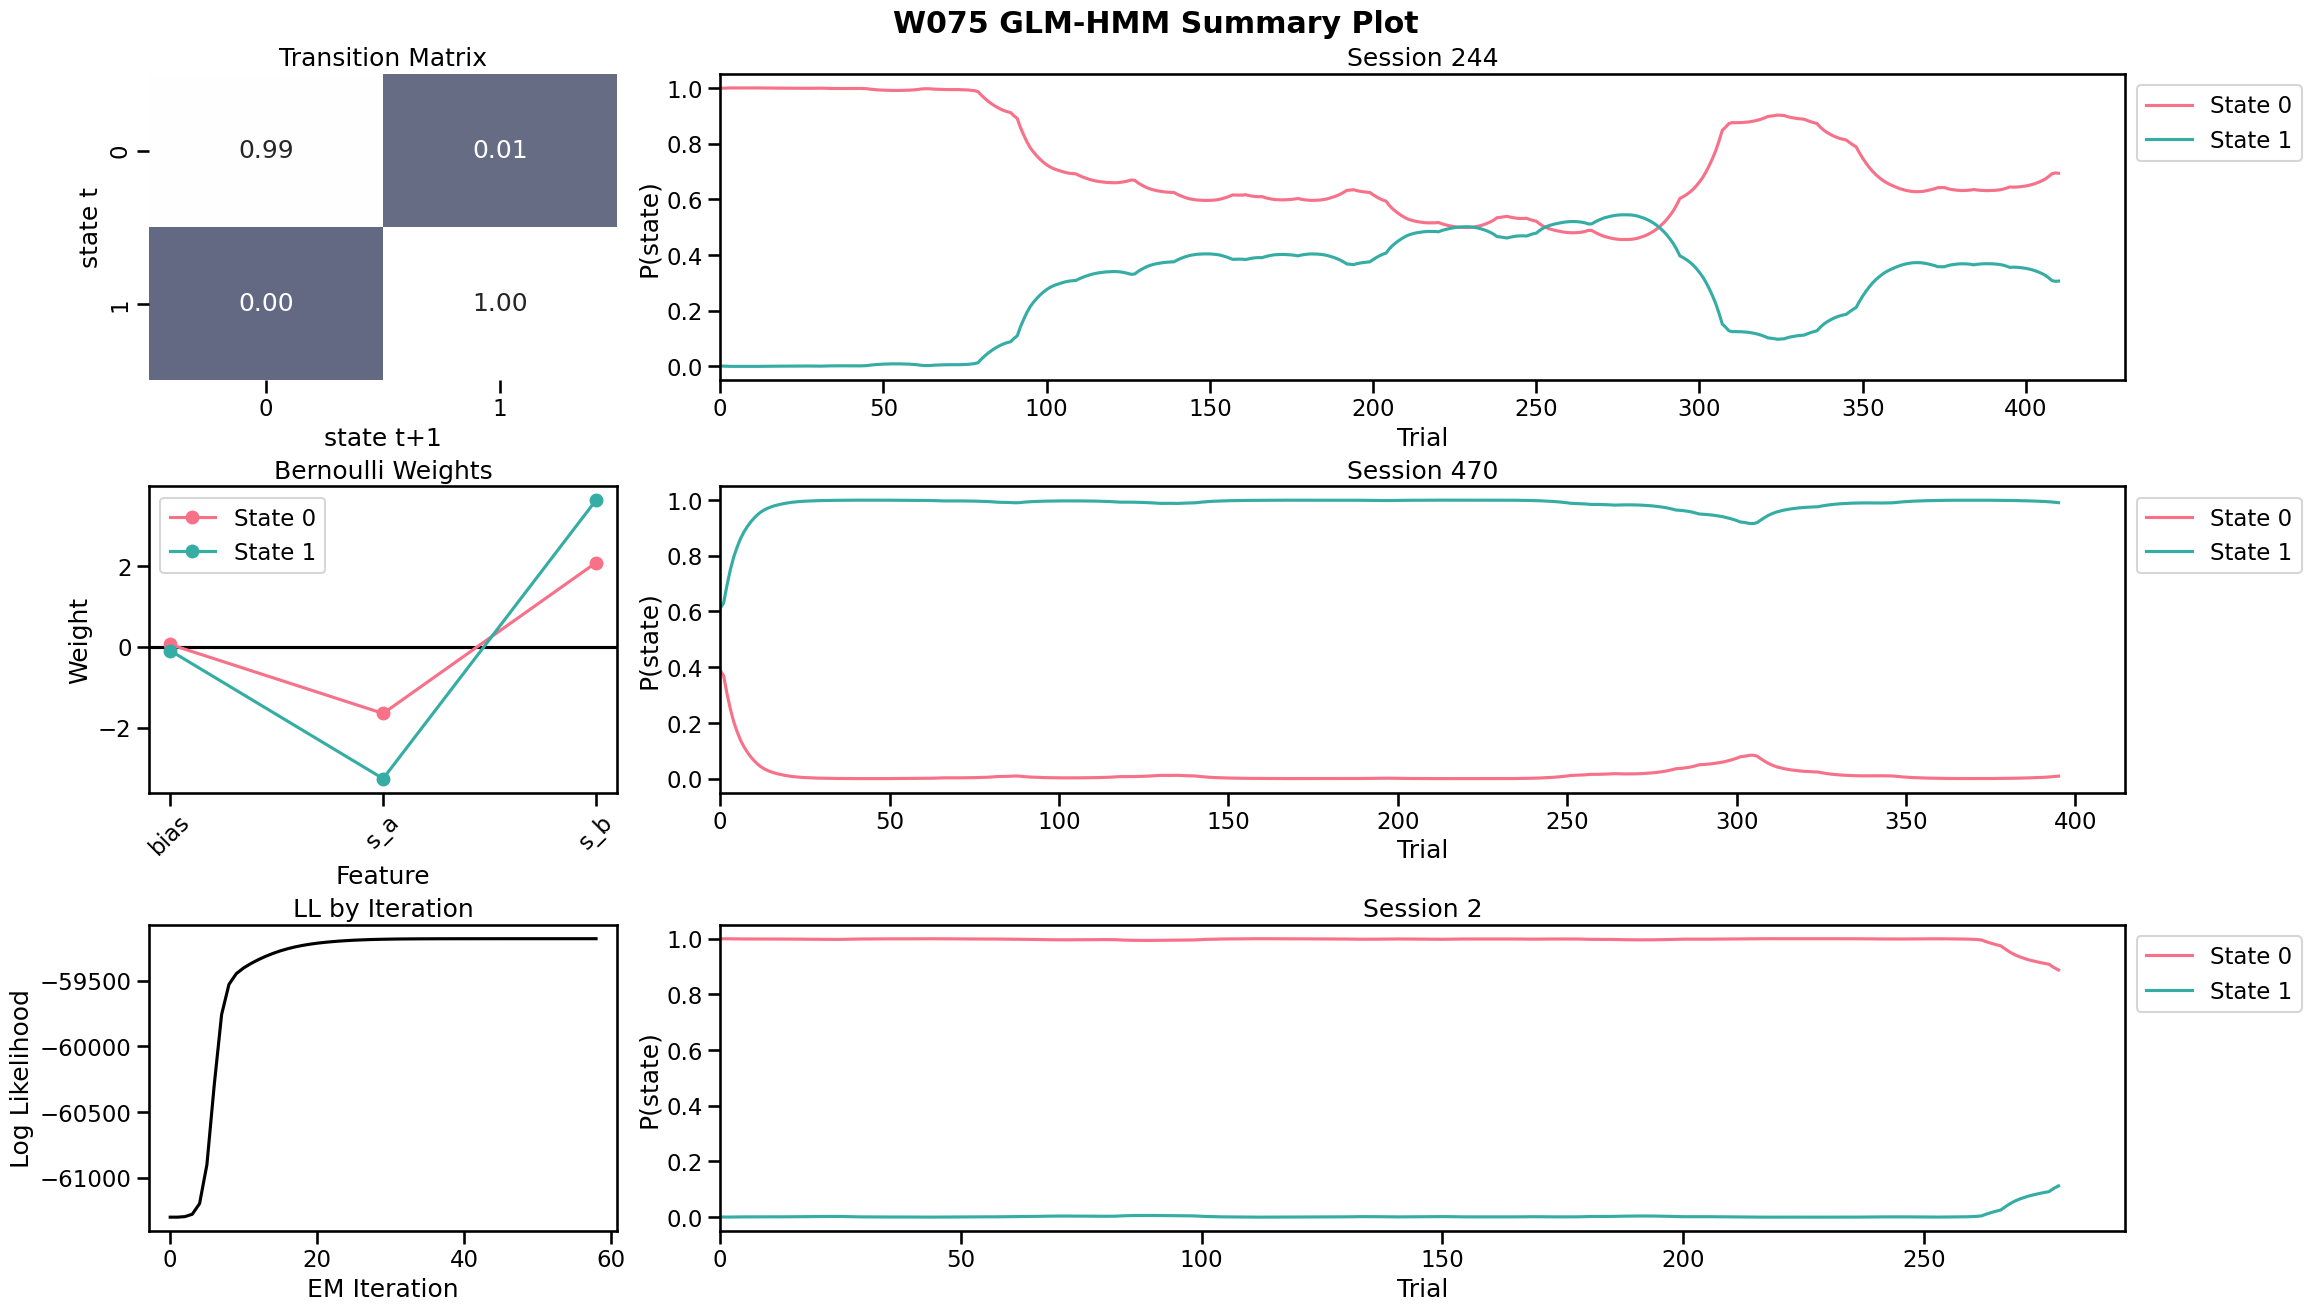

In [32]:
plot_bernoulli_glmhmm_summary(fit_ll, glm_hmm, animal_id[0], Xs, ys, seed=None)